# Multi-Frame Motion Deblur Recovery
Reconstruction of Resolution Target

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import libwallerlab.projects.motiondeblur as md
from libwallerlab.utilities.io import Dataset

# Debugging
import matplotlib.pyplot as plt
import llops as yp
import ndoperators as ops
import numpy as np

yp.setDefaultBackend('numpy')

('libforge.1.dylib', '/opt/arrayfire/lib/libforge.1.dylib')


## Load Data

In [2]:
# Define user for path setting
user = 'zack'

if user == 'sarah':
    dataset_path_stem = '/home/sarah/Dropbox/deblurring/motiondeblur_datasets/'
else:
    dataset_path_stem = '/Users/zfphil/Dropbox/Berkeley/Datasets/motiondeblur_datasets/'

# Proces dataet path
dataset_path = 'res_target_color_coded_raster_motiondeblur_2018_05_22_19_17_45'
# dataset_path = 'res_target_color_strobe_raster_motiondeblur_2018_05_22_19_17_18'
# dataset_path = 'res_target_color_stopandstare_raster_multi_contrast_2018_05_22_19_16_26'
filename = dataset_path_stem + dataset_path

# Load dataset
dataset = Dataset(filename, frame_subset=range(20,23))

# Perform motion-deblur related preprocessing
md.preprocess(dataset)

Metadata indicates background has already been subtracted.


## Registering Frames without deblurring

In [3]:
# Options for testing:
# 1. Generate a combineCrop function which combines the crop operators, assuming the same arguments
# 2. Generate a mask for the coverage of each


In [209]:
args

{'pad_value': 0, 'crop_offset': (0, 0)}

Image size is 1080 x 1280, Object size is 1080 x 3639, Blur kernel size is 1080 x 1591
Processed kernel 1 of 3
Processed kernel 2 of 3
Processed kernel 3 of 3


<IPython.core.display.Javascript object>


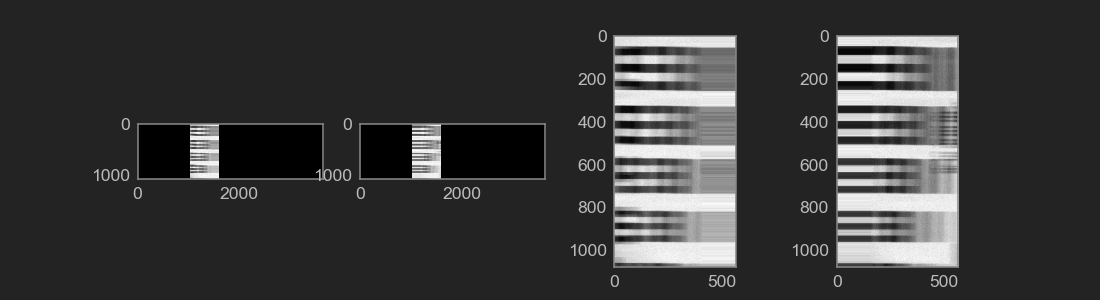

<IPython.core.display.Javascript object>


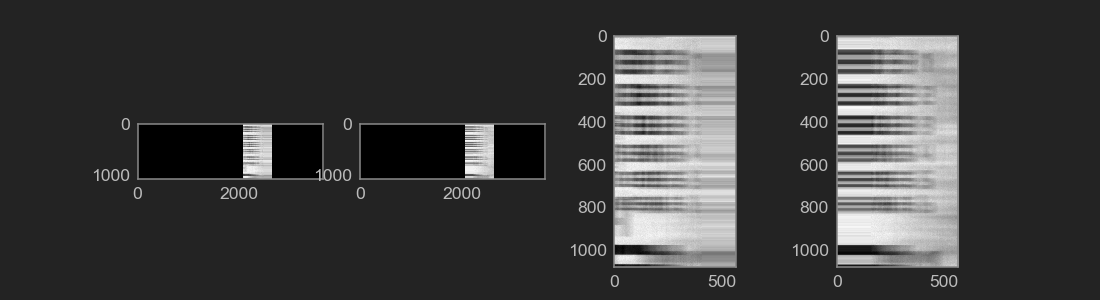

[array([0., 0.]), array([0., 0.])]


In [322]:
import libwallerlab.utilities.registration as registration
from skimage import filters
recon = md.Reconstruct(dataset)
recon.gen_forward_model() #TODO check the shift (adjust_by=[[0,-313-1024], [0,-313-1024], [0,0]])

# Get information from recon class
R0 = recon.R0.stack_operators[0]
y_list = recon.y_list
CR_list = recon.Ri.stack_operators
b_list = recon.blur_kernel_list

pad_mode = 'edge'

# Set CR
for cr in CR_list:
    args = cr.arguments
    args['pad_value'] = pad_mode
    cr.arguments = args
    
args = R0.arguments
args['pad_value'] = pad_mode
R0.arguments = args

debug = True
use_overlap_region = False
offsets = []
for index in range(len(y_list) - 1):
    
    # Get measurements
    _x_previous_measurement = y_list[index]
    _x_current_measurement = y_list[index + 1]
    
    # 1. Pad to conv_1 support
    _x_previous_measurement = R0.H * _x_previous_measurement
    _x_current_measurement = R0.H * _x_current_measurement
    
    # 2. Pad to full object support
    _x_previous_measurement = CR_list[index].H * _x_previous_measurement
    _x_current_measurement = CR_list[index + 1].H * _x_current_measurement
    
    # Get masks
    mask_previous = yp.astype(CR_list[index].singular_values, yp.getDatatype(y_list[0]))
    mask_current = yp.astype(CR_list[index + 1].singular_values, yp.getDatatype(y_list[0]))
    
    # Crop these to correct size if requested (for efficency).
    if use_overlap_region:
        # Filter by R0:
        mask_previous[mask_previous > 0] *= yp.vec(R0.singular_values)
        mask_current[mask_current > 0] *= yp.vec(R0.singular_values)

        # Combine
        mask = mask_previous * mask_current

        # Get bounding box of mask
        mask_bbox = yp.boundingBox(mask, return_roi=True)

        x_previous_measurement = yp.crop(_x_previous_measurement, mask_bbox.size,
                                      crop_start=mask_bbox.start,
                                      out_of_bounds_placeholder=0)

        x_current_measurement = yp.crop(_x_current_measurement, mask_bbox.size,
                                      crop_start=mask_bbox.start,
                                      out_of_bounds_placeholder=0)
    else:
        mask = mask_previous * mask_current
        
        # Get bounding box of mask
        mask_bbox = yp.boundingBox(mask, return_roi=True)
        
        x_previous_measurement = yp.crop(_x_previous_measurement, mask_bbox.size,
                                      crop_start=mask_bbox.start,
                                      out_of_bounds_placeholder=0)

        x_current_measurement = yp.crop(_x_current_measurement, mask_bbox.size,
                                      crop_start=mask_bbox.start,
                                      out_of_bounds_placeholder=0)
    
    
    # Show debugging header
    if debug:
        import matplotlib.pyplot as plt
        from llops import Ft, iFt, conj, argmax
        plt.figure(figsize=(11, 3))
        plt.subplot(141)
        plt.imshow(abs(mask * _x_previous_measurement))
        plt.subplot(142)
        plt.imshow(abs(mask * _x_current_measurement))
        plt.subplot(143)
        plt.imshow(abs(x_previous_measurement))
        plt.subplot(144)
        plt.imshow(abs(x_current_measurement))

    # Perform registration
    offsets.append(registration.registerImage(x_previous_measurement, x_current_measurement, preprocess_methods=[]))
    
print(offsets)

<IPython.core.display.Javascript object>


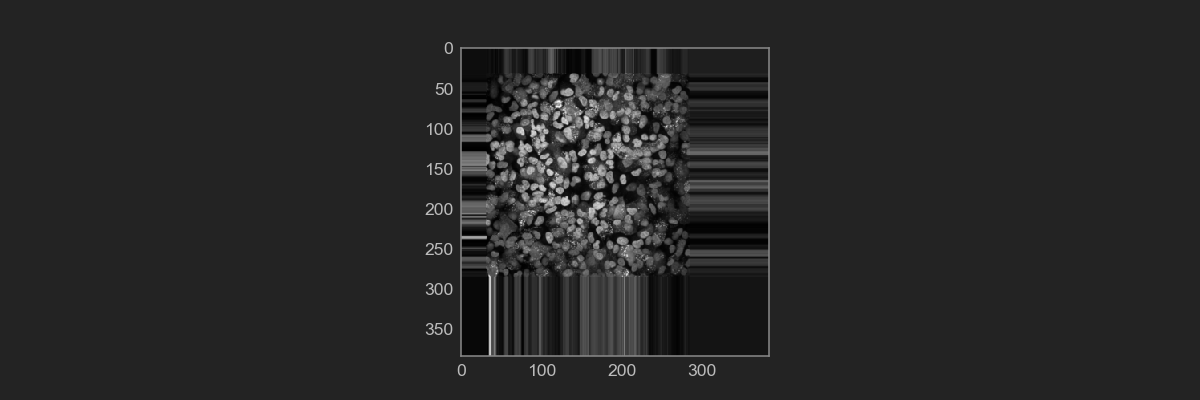

In [315]:
import libwallerlab.utilities.simulation as sim
x = sim.cells()

pad_size = [int(s * 1.5) for s in yp.shape(x)]
xp = yp.pad(x, pad_size, crop_start=(30,30), pad_value='edge')

plt.figure()
plt.imshow(yp.abs(xp))


In [318]:
import skimage

P = ops.Pad(yp.shape(x_previous_measurement), [int(2 * s) for s in yp.shape(x_previous_measurement)], pad_value='edge')
skimage.feature.register_translation(P * x_previous_measurement, P * x_current_measurement)[0]

array([   0., -153.])

[   0. -153.]


<IPython.core.display.Javascript object>


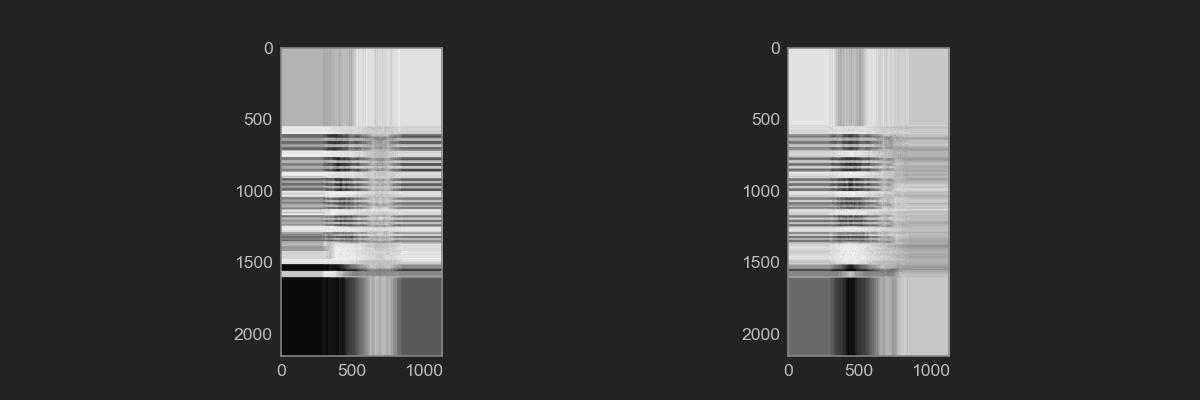

In [320]:
P = ops.Pad(yp.shape(x_previous_measurement), [int(2 * s) for s in yp.shape(x_previous_measurement)], pad_value='edge')
print(skimage.feature.register_translation(P * x_previous_measurement, P * x_current_measurement)[0])

plt.figure()
plt.subplot(121)
plt.imshow(yp.abs(P * x_previous_measurement))
plt.subplot(122)
plt.imshow(yp.abs(P * x_current_measurement))

<IPython.core.display.Javascript object>


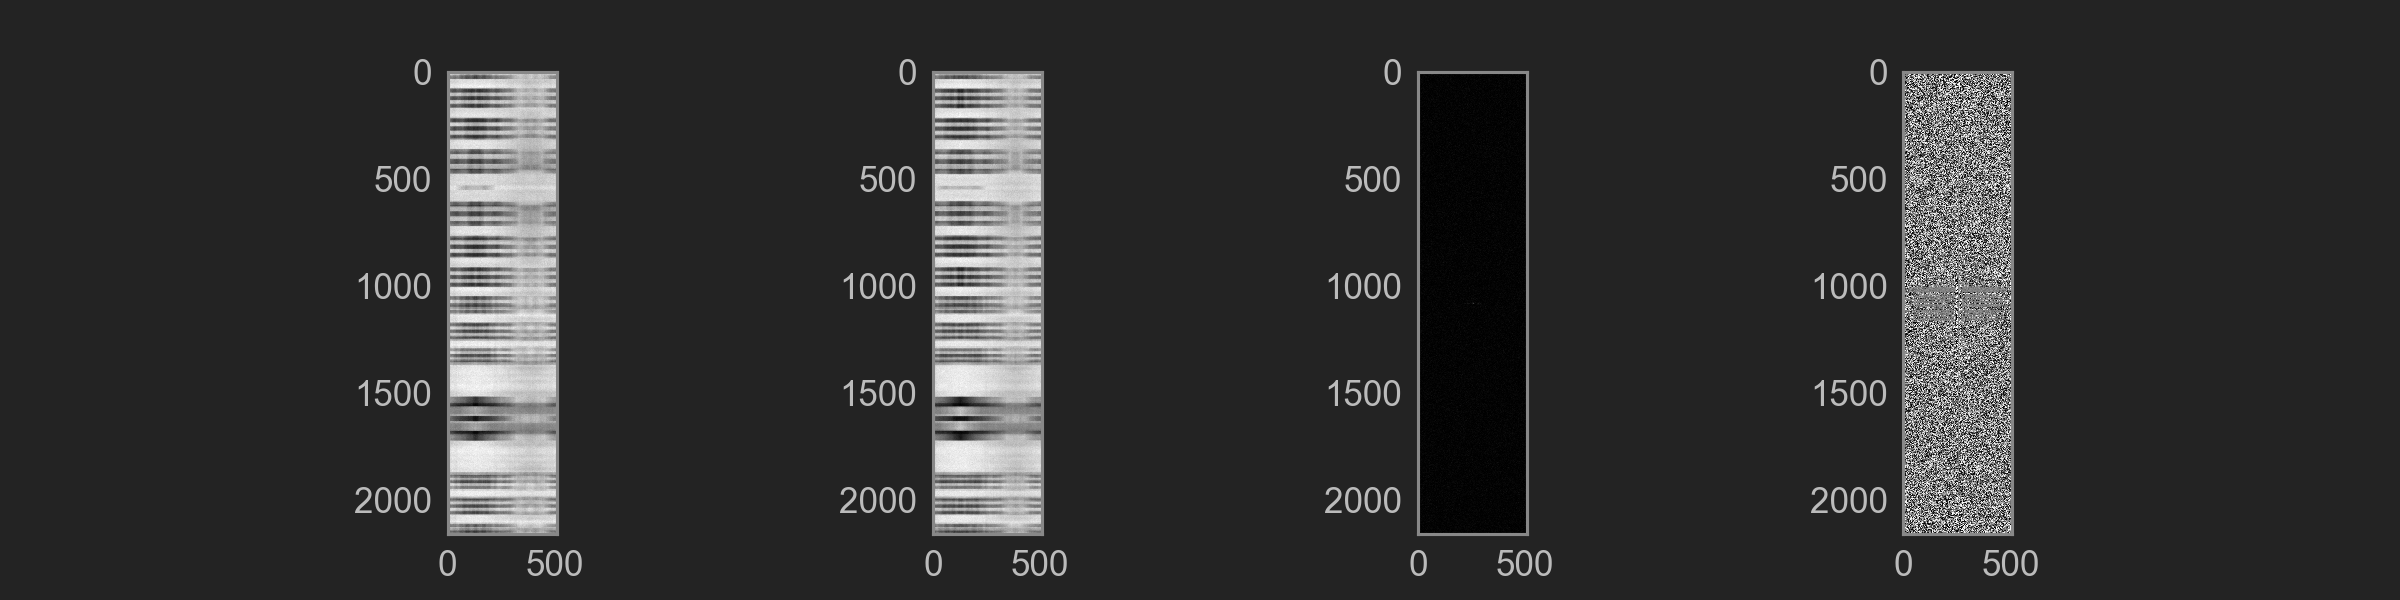

array([1.+0.j, 1.+0.j], dtype=complex64)

In [133]:
image1, image2 = yp.dcopy(x_previous_measurement), yp.dcopy(x_current_measurement)
debug = True

# Pad
P = ops.Pad(yp.shape(x_previous_measurement), [int(2 * s) for s in yp.shape(x_previous_measurement)], pad_value='reflect')
image1, image2 = (P * image1, P * image2)

# image1, image2 = images
# Take Fourier Transform
xf_1, xf_2 = (yp.Ft(image1), yp.Ft(image2))

# Compute normalized cross-correlation
phasor = (yp.conj(xf_1) * xf_2) / yp.abs(yp.conj(xf_1) * xf_2)

phasor[yp.isnan(phasor)] = 0

# Convert phasor to delta function
delta = yp.iFt(phasor)

if debug:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 3))
    plt.subplot(141)
    plt.imshow(yp.abs(yp.iFt(xf_1)))
    plt.subplot(142)
    plt.imshow(yp.abs(yp.iFt(xf_2)))
    plt.subplot(143)
    if yp.ndim(delta) > 1:
        plt.imshow(yp.abs(delta))
    else:
        plt.plot(yp.abs(delta))
        
    plt.subplot(144)
    plt.imshow(yp.angle(phasor))
        
# Calculate maximum and return
center = True
if not center:
    shift = yp.asarray(yp.argmax(delta))
else:
    shift = yp.asarray(yp.argmax(delta)) - yp.asarray(yp.shape(delta)) / 2
shift

In [160]:
solvers

NameError: name 'solvers' is not defined

In [205]:
_shape = yp.shape(x_current_measurement)

# Define operators
R = ops.PhaseRamp(_shape)
F = ops.FourierTransform(_shape)
D = ops.Diagonalize(x_current_measurement, inside_operator=F)
L2 = ops.L2Norm(_shape)

# Define objective function
objective = L2 * (D * R - (F * x_previous_measurement))

# Perform gradient descent
x_init = yp.zeros(objective.N)

import ndoperators.solvers as solvers

solver = solvers.GradientDescent(objective, display_type='text', use_nesterov_acceleration=True)
solver.solve(initialization=x_init, iteration_count=10, step_size=9e-9)
# for _ in yp.display.progressBar(range(100), 'Iterations'):
#     x -= 5e-9 * objective.gradient(x)
#     print(yp.scalar(objective(x)))

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    1.63e+08    |       0.00       |    0.00e+00    | 2048.1 MB /    0.0 MB  |
|    1   |    1.59e+08    |       0.13       |    3.91e-01    | 2058.6 MB /    0.0 MB  |
|    2   |    1.63e+08    |       0.31       |    9.65e-02    | 2067.0 MB /    0.0 MB  |
|    3   |    1.61e+08    |       0.49       |    2.19e-01    | 2075.4 MB /    0.0 MB  |
|    4   |    1.78e+08    |       0.68       |    5.30e-02    | 2083.9 MB /    0.0 MB  |
|    5   |    2.24e+08    |       0.87       |    3.01e-01    | 2054.3 MB /    0.0 MB  |
|    6   |    7.34e+17    |       1.06       |    2.98e+00    | 2054.3 MB /    0.0 MB  |
|    7   |    nan    |       1.20       |    9.47e+10    | 2056.4 MB /    0.0 MB  |
|    8   |    nan    |       1.33       |    nan    | 2073.5 MB /    0.0 MB  |
|    9   |    nan    |       1.43   

array([[nan+nanj],
       [nan+nanj]], dtype=complex64)

In [176]:
_shape = yp.shape(x_current_measurement)

# Define operators
R = ops.Registration(x_current_measurement)
L2 = ops.L2Norm(_shape)

# Define objective function
objective = L2 * (R - x_previous_measurement)

# Perform gradient descent
x_init = yp.zeros(objective.N)

import ndoperators.solvers as solvers

solver = solvers.GradientDescent(objective, display_type='text', use_nesterov_acceleration=True)
solver.solve(initialization=x_init, iteration_count=10, step_size=8e-9)
# for _ in yp.display.progressBar(range(100), 'Iterations'):
#     x -= 5e-9 * objective.gradient(x)
#     print(yp.scalar(objective(x)))

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    9.65e+02    |       0.00       |    0.00e+00    | 2440.6 MB /    0.0 MB  |
|    1   |    9.44e+02    |       0.21       |    3.51e-01    | 2457.3 MB /    0.0 MB  |
|    2   |    9.42e+02    |       0.46       |    8.28e-02    | 2459.4 MB /    0.0 MB  |
|    3   |    9.36e+02    |       0.72       |    1.74e-01    | 2459.1 MB /    0.0 MB  |
|    4   |    9.36e+02    |       0.97       |    4.67e-02    | 2459.1 MB /    0.0 MB  |
|    5   |    9.33e+02    |       1.22       |    1.08e-01    | 2473.9 MB /    0.0 MB  |
|    6   |    9.33e+02    |       1.48       |    4.27e-02    | 2476.0 MB /    0.0 MB  |
|    7   |    9.32e+02    |       1.74       |    7.57e-02    | 2467.3 MB /    0.0 MB  |
|    8   |    9.32e+02    |       1.97       |    4.13e-02    | 2467.3 MB /    0.0 MB  |
|    9   |    9.31e+0

array([[ 0.47125155+0.01283032j],
       [-0.12591161+0.1615234j ]], dtype=complex64)

In [178]:
positions = yp.grid([20] * 2)

shifts = 

1


In [189]:
positions_to_scan = yp.transpose(yp.asarray([yp.vec(p) for p in positions]))

funcvals = []
for pos in yp.display.progressBar(positions_to_scan):
    funcvals += [objective(pos)]

In [198]:
len(funcvals)

[autoreload of libwallerlab.utilities.registration failed: Traceback (most recent call last):
  File "/Users/zfphil/anaconda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/Users/zfphil/anaconda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 374, in superreload
    module = reload(module)
  File "/Users/zfphil/anaconda/lib/python3.7/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Users/zfphil/anaconda/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File 

<IPython.core.display.Javascript object>


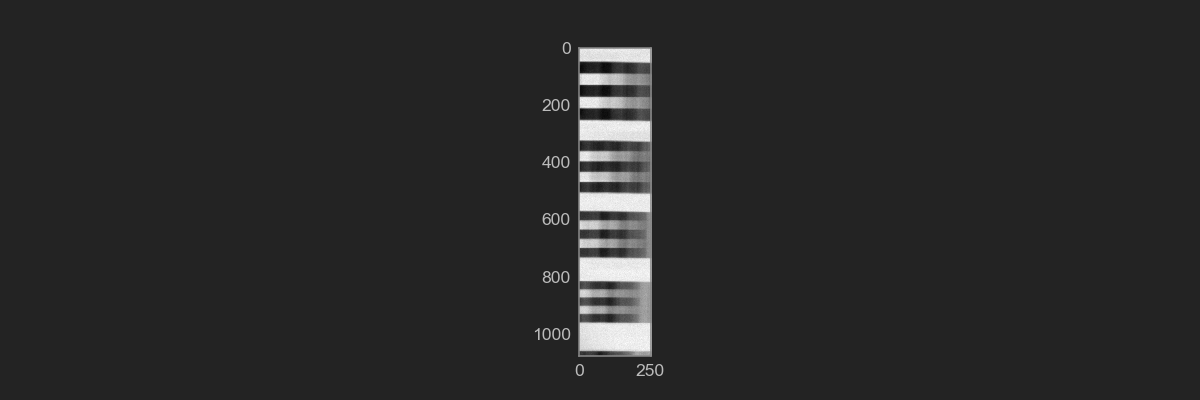

In [79]:
plt.figure()
plt.imshow(yp.real(x_current_measurement))

### Break-out for Inversion Process

In [ ]:
import libwallerlab.utilities.registration as register
plt.figure()
plt.subplot(131)
plt.imshow(yp.abs(y_prev))
plt.subplot(132)
plt.imshow(yp.abs(y))

print(register.registerImage(y, y_prev))

In [ ]:


recon = md.Reconstruct(dataset)
recon.gen_forward_model() #TODO check the shift (adjust_by=[[0,-313-1024], [0,-313-1024], [0,0]])

# A = ops.Vstack(operators)
A = recon.A

A.inverse_regularizer = 1e-2
y = recon.R0.H * recon.y

plt.figure(figsize=(15,6))
plt.subplot(131)
plt.imshow(yp.abs(y))
plt.colorbar()

plt.subplot(132)
plt.imshow(yp.abs(A.inv * y))
plt.colorbar()

## Recon with Registration

In [ ]:
recon = md.Reconstruct(dataset)
recon.gen_forward_model() #TODO check the shift (adjust_by=[[0,-313-1024], [0,-313-1024], [0,0]])

# A = ops.Vstack(operators)
A = recon.A
C = recon.A.suboperators[0]
CR = recon.A.suboperators[1]
y = recon.R0.H * recon.y

# Generate a multi-measurement registration operator
axes = [0,1]
Q = ops.MultiMeasurementRegistration(CR.stack_operators, debug=False, crop_to_overlap=True, axes=axes)

# Generate full operator
A_shift = C * Q 

# Perform inversion to recover shifts
shift_recovered = A_shift.inv * y

# Reshape to correct size
_shift_recovered = yp.reshape(shift_recovered, (Q.nops, len(axes)))

# Assign the full, 2D recovered shifts
new_offset = yp.zeros((len(Q.stack_operators), 2))
for index, ax in enumerate(axes):
    new_offset[:,ax] = _shift_recovered[:,index]


In [ ]:
# Set shift to zero (for comparison)
args = CR.arguments
for arg, shift in zip(args, new_offset):
    arg['crop_offset'] = -np.asarray((0,0))
CR.arguments = args

# Form forward model
A_object = C * CR
A_object.inverse_regularizer = 1e-2

# Solve for uncorrected object
x_uncorrected = A_object.inv * y

# Set shifts
args = CR.arguments
for arg, shift in zip(args, new_offset):
    arg['crop_offset'] = -np.asarray(shift).ravel()
CR.arguments = args

# Solve for corrected object
x_corrected = A_object.inv * y

# Show results
plt.figure()
plt.subplot(211)
plt.imshow(yp.real(x_uncorrected))
plt.subplot(212)
plt.imshow(yp.real(x_corrected))

## Single-Frame Recon with External Inversion

In [ ]:
_shift_recovered

In [ ]:
index = 2
y = recon.y_list[index]
h = recon.blur_kernel_list[index]
R0 = ops.Pad(recon.y_list[index].shape, h.shape, pad_value='mean')
h = R0.H * h

F = ops.FourierTransform(h.shape)
hf = F * h

reg = 1e-7

H_inv = ops.Diagonalize(yp.conj(hf) / (yp.abs(hf) ** 2 + reg))

A_inv = F.H * H_inv * F

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(yp.abs(y))
plt.colorbar()
plt.subplot(122)
plt.imshow(yp.abs(A_inv * y))
plt.colorbar()

## Single-Frame Recon

In [ ]:
recon = md.Reconstruct(dataset)
recon.gen_forward_model(pad_value='mean') #TODO check the shift (adjust_by=[[0,-313-1024], [0,-313-1024], [0,0]])

index = 2
A = recon.C.operators[index]
y = recon.R0.operators[index].H * recon.y_list[index]

A.inverse_regularizer = 1e-8
plt.figure()
plt.imshow(yp.abs(A.inv * y))
plt.colorbar()

### Object-Oriented Recontruction

In [ ]:
recon = md.Reconstruct(dataset)
recon.gen_forward_model() #TODO check the shift (adjust_by=[[0,-313-1024], [0,-313-1024], [0,0]])
# recon.reconstruct(5, reg_types={'l2': 1e-1} ) # 20
recon.invert(reg_types={'l2': 1e-7}, sequential_pad=True, sequential_pad_iteration_count=1)
recon.show(figsize=(11,5), clim=False)